# So sánh Thuật toán Optimization trên bài toán Ackley Function

## Comparison: Hill Climbing (Traditional) vs Cuckoo Search

### Ackley Function
- **Type**: Continuous optimization benchmark
- **Global minimum**: f(0, 0, ..., 0) = 0
- **Domain**: typically [-5, 5]^d
- **Characteristics**: Nhiều local minima, test khả năng escape local optima

## Các metrics đánh giá:
1. **Convergence Speed** (Tốc độ hội tụ): Tốc độ đạt được global minimum
2. **Computational Complexity** (Độ phức tạp tính toán): Số evaluations và thời gian
3. **Robustness** (Tính bền vững): Consistency across different dimensions
4. **Scalability** (Khả năng mở rộng): Performance khi tăng dimensions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import seaborn as sns
from typing import List, Tuple, Dict
import sys
import os

# Add parent directory to path
sys.path.insert(0, os.path.abspath(".."))

from src.swarm_algo.cuckoo import CuckooSearch
from src.search_algo.hill_climbing import HillClimbing, Problem
from src.problem.ackley import AckleyFunction

# Set style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["font.size"] = 10

## 1. Load Data và Helper Functions

In [2]:
ACKLEY_DATA_FOLDER = "../data/ackley/"
BOUNDS = (-5.0, 5.0)  # Ackley domain


def get_ackley_problem(problem_num: int) -> Tuple[int, np.ndarray, float]:
    """Load Ackley problem using AckleyFunction class"""
    ackley = AckleyFunction(PROBLEM_FOLDER=ACKLEY_DATA_FOLDER, PROBLEM=problem_num)
    return ackley.dimension, ackley.input_vector, ackley.initial_value


def calculate_error_percentage(result_value, optimal_value=0.0):
    """Calculate error percentage from optimal (0 for Ackley)"""
    epsilon = 1e-10
    if optimal_value == 0:
        return abs(result_value) * 100  # Percentage
    return abs(result_value - optimal_value) / (abs(optimal_value) + epsilon) * 100

## 2. Implement Algorithm Wrappers

In [3]:
class AckleySolver:
    """Base solver for Ackley function"""

    def __init__(self, dimension, bounds=(-5.0, 5.0)):
        self.dimension = dimension
        self.bounds = bounds
        self.optimal_value = 0.0  # Global minimum


class AckleyProblemForHC(Problem):
    """Ackley Problem adapter for Hill Climbing"""

    def __init__(self, problem_num: int, step_size=0.1, data_folder="../data/ackley/"):
        self.ackley = AckleyFunction(PROBLEM_FOLDER=data_folder, PROBLEM=problem_num)
        self.dimension = self.ackley.dimension
        self.bounds = (-5.0, 5.0)
        self.step_size = step_size

    def generate_initial_solution(self):
        return np.random.uniform(self.bounds[0], self.bounds[1], self.dimension)

    def evaluate(self, solution):
        return self.ackley.calculate_fitness(solution)

    def get_neighbors(self, solution):
        neighbors = []
        for i in range(self.dimension):
            neighbor_pos = solution.copy()
            neighbor_pos[i] += self.step_size
            if self.bounds[0] <= neighbor_pos[i] <= self.bounds[1]:
                neighbors.append(neighbor_pos)

            neighbor_neg = solution.copy()
            neighbor_neg[i] -= self.step_size
            if self.bounds[0] <= neighbor_neg[i] <= self.bounds[1]:
                neighbors.append(neighbor_neg)
        return neighbors

    def is_valid(self, solution):
        return np.all((solution >= self.bounds[0]) & (solution <= self.bounds[1]))


class AckleyHillClimbing(AckleySolver):
    """Hill Climbing wrapper for Ackley"""

    def __init__(
        self, problem_num: int, bounds=(-5.0, 5.0), data_folder="../data/ackley/"
    ):
        self.ackley = AckleyFunction(PROBLEM_FOLDER=data_folder, PROBLEM=problem_num)
        self.dimension = self.ackley.dimension
        self.bounds = bounds
        self.optimal_value = 0.0
        self.problem_num = problem_num

    def solve(self, max_iters=300, variant="steepest", step_size=0.1):
        start_time = time.time()
        problem = AckleyProblemForHC(self.problem_num, step_size)

        convergence_history = []
        current_solution = problem.generate_initial_solution()
        current_fitness = problem.evaluate(current_solution)
        convergence_history.append(current_fitness)

        best_solution = current_solution.copy()
        best_fitness = current_fitness
        evaluations = 1

        for iteration in range(max_iters):
            neighbors = problem.get_neighbors(current_solution)
            if not neighbors:
                break

            improved = False
            if variant == "steepest":
                best_neighbor = None
                best_neighbor_fitness = current_fitness

                for neighbor in neighbors:
                    neighbor_fitness = problem.evaluate(neighbor)
                    evaluations += 1
                    if neighbor_fitness < best_neighbor_fitness:
                        best_neighbor_fitness = neighbor_fitness
                        best_neighbor = neighbor
                        improved = True

                if improved:
                    current_solution = best_neighbor
                    current_fitness = best_neighbor_fitness

            if current_fitness < best_fitness:
                best_fitness = current_fitness
                best_solution = current_solution.copy()

            convergence_history.append(best_fitness)
            if not improved:
                break

        end_time = time.time()
        return {
            "solution": best_solution,
            "value": best_fitness,
            "time": end_time - start_time,
            "iterations": len(convergence_history),
            "convergence_history": convergence_history,
            "evaluations": evaluations,
        }


class AckleyCuckoo(AckleySolver):
    """Cuckoo Search wrapper for Ackley"""

    def __init__(
        self, problem_num: int, bounds=(-5.0, 5.0), data_folder="../data/ackley/"
    ):
        self.ackley = AckleyFunction(PROBLEM_FOLDER=data_folder, PROBLEM=problem_num)
        self.dimension = self.ackley.dimension
        self.bounds = bounds
        self.optimal_value = 0.0

    def solve(self, n_cuckoos=50, max_generations=300, pa=0.25, beta=1.5):
        """Solve using Cuckoo Search"""
        start_time = time.time()

        # Create Cuckoo Search optimizer
        cuckoo = CuckooSearch(
            ndim=self.dimension, n_cuckoos=n_cuckoos, pa=pa, beta=beta
        )

        # Cuckoo works in [0,1]^d, need to scale
        def scaled_objective(x_normalized):
            x_scaled = x_normalized * (self.bounds[1] - self.bounds[0]) + self.bounds[0]
            return self.ackley.calculate_fitness(x_scaled)

        cuckoo.set_objective_function(scaled_objective)

        best_position_norm, best_value, convergence_history = cuckoo.run(
            max_generations, visualize=False
        )

        # Scale back to original domain
        best_position = (
            best_position_norm * (self.bounds[1] - self.bounds[0]) + self.bounds[0]
        )

        end_time = time.time()

        return {
            "solution": best_position,
            "value": best_value,
            "time": end_time - start_time,
            "iterations": max_generations,
            "convergence_history": convergence_history,
            "evaluations": n_cuckoos * max_generations,
        }

## 3. Benchmark Functions

In [4]:
def run_comparison(problem_numbers, algorithms_config, n_runs=5):
    """Run comparison across multiple problems with multiple runs"""
    results = []

    for prob_num in problem_numbers:
        print(f"\n{'='*70}")
        print(f"Problem {prob_num}")
        print(f"{'='*70}")

        dimension, initial_vector, initial_value = get_ackley_problem(prob_num)

        print(f"Dimension: {dimension}")
        print(f"Initial value: {initial_value:.6f}")
        print(f"Global optimum: 0.0")

        for algo_name, algo_params in algorithms_config.items():
            print(f"\nRunning {algo_name}...")
            run_results = []

            for run in range(n_runs):
                try:
                    if algo_name == "Hill Climbing":
                        solver = AckleyHillClimbing(prob_num)
                        result = solver.solve(**algo_params)
                    elif algo_name == "Cuckoo Search":
                        solver = AckleyCuckoo(prob_num)
                        result = solver.solve(**algo_params)

                    run_results.append(result)
                except Exception as e:
                    print(f"  Run {run+1} Error: {e}")

            if run_results:
                values = [r["value"] for r in run_results]
                times = [r["time"] for r in run_results]
                iterations = [r["iterations"] for r in run_results]
                evaluations = [r["evaluations"] for r in run_results]

                best_run = run_results[np.argmin(values)]

                result_dict = {
                    "Problem": prob_num,
                    "Algorithm": algo_name,
                    "Dimension": dimension,
                    "Best Value": np.min(values),
                    "Mean Value": np.mean(values),
                    "Std Value": np.std(values),
                    "Mean Time (s)": np.mean(times),
                    "Std Time (s)": np.std(times),
                    "Iterations": int(np.mean(iterations)),
                    "Evaluations": int(np.mean(evaluations)),
                    "Convergence History": best_run["convergence_history"],
                }

                results.append(result_dict)

                print(f"  Best value: {np.min(values):.6f}")
                print(f"  Mean value: {np.mean(values):.6f} ± {np.std(values):.6f}")
                print(f"  Mean time: {np.mean(times):.4f}s")

    return pd.DataFrame(results)

## 4. Run Experiments

### 4.1 Low Dimensions (2D-5D)

In [5]:
low_dim_problems = [1, 2, 3, 4]

algorithms_config = {
    "Hill Climbing": {"max_iters": 200, "variant": "steepest", "step_size": 0.1},
    "Cuckoo Search": {"n_cuckoos": 30, "max_generations": 200, "pa": 0.25, "beta": 1.5},
}

low_dim_results = run_comparison(low_dim_problems, algorithms_config, n_runs=10)
print("\n" + "=" * 70)
print("Summary for Low Dimensions")
print("=" * 70)
print(low_dim_results.drop("Convergence History", axis=1).to_string(index=False))


Problem 1
Dimension: 5
Initial value: 21.812432
Global optimum: 0.0

Running Hill Climbing...
  Best value: 4.214804
  Mean value: 8.391557 ± 1.962605
  Mean time: 0.0009s

Running Cuckoo Search...
  Best value: 0.023471
  Mean value: 0.059082 ± 0.014362
  Mean time: 0.1086s

Problem 2
Dimension: 5
Initial value: 21.670581
Global optimum: 0.0

Running Hill Climbing...
  Best value: 4.957983
  Mean value: 8.582182 ± 1.654553
  Mean time: 0.0009s

Running Cuckoo Search...
  Best value: 0.023471
  Mean value: 0.059082 ± 0.014362
  Mean time: 0.1086s

Problem 2
Dimension: 5
Initial value: 21.670581
Global optimum: 0.0

Running Hill Climbing...
  Best value: 4.957983
  Mean value: 8.582182 ± 1.654553
  Mean time: 0.0009s

Running Cuckoo Search...
  Best value: 0.021023
  Mean value: 0.051163 ± 0.023732
  Mean time: 0.1084s

Problem 3
Dimension: 5
Initial value: 21.785701
Global optimum: 0.0

Running Hill Climbing...
  Best value: 3.920083
  Mean value: 7.963451 ± 2.503488
  Mean time: 0.00

### 4.2 Medium Dimensions (10D-20D)

In [6]:
medium_dim_problems = [5, 6, 7]

algorithms_config_medium = {
    "Hill Climbing": {"max_iters": 300, "variant": "steepest", "step_size": 0.1},
    "Cuckoo Search": {"n_cuckoos": 50, "max_generations": 300, "pa": 0.25, "beta": 1.5},
}

medium_dim_results = run_comparison(
    medium_dim_problems, algorithms_config_medium, n_runs=10
)
print("\n" + "=" * 70)
print("Summary for Medium Dimensions")
print("=" * 70)
print(medium_dim_results.drop("Convergence History", axis=1).to_string(index=False))


Problem 5
Dimension: 5
Initial value: 19.865241
Global optimum: 0.0

Running Hill Climbing...
  Best value: 5.501685
  Mean value: 8.723065 ± 1.669386
  Mean time: 0.0010s

Running Cuckoo Search...
  Best value: 0.003008
  Mean value: 0.026366 ± 0.016226
  Mean time: 0.2708s

Problem 6
Dimension: 5
Initial value: 0.000000
Global optimum: 0.0

Running Hill Climbing...
  Best value: 7.490916
  Mean value: 9.000849 ± 0.894897
  Mean time: 0.0010s

Running Cuckoo Search...
  Best value: 0.003008
  Mean value: 0.026366 ± 0.016226
  Mean time: 0.2708s

Problem 6
Dimension: 5
Initial value: 0.000000
Global optimum: 0.0

Running Hill Climbing...
  Best value: 7.490916
  Mean value: 9.000849 ± 0.894897
  Mean time: 0.0010s

Running Cuckoo Search...
  Best value: 0.010357
  Mean value: 0.036142 ± 0.017229
  Mean time: 0.2801s

Problem 7
Dimension: 5
Initial value: 19.004259
Global optimum: 0.0

Running Hill Climbing...
  Best value: 4.727173
  Mean value: 8.353753 ± 2.144032
  Mean time: 0.0008

### 4.3 High Dimensions (30D+)

In [7]:
high_dim_problems = [8, 9, 10]

algorithms_config_high = {
    "Hill Climbing": {"max_iters": 500, "variant": "steepest", "step_size": 0.05},
    "Cuckoo Search": {"n_cuckoos": 50, "max_generations": 500, "pa": 0.25, "beta": 1.5},
}

high_dim_results = run_comparison(high_dim_problems, algorithms_config_high, n_runs=10)
print("\n" + "=" * 70)
print("Summary for High Dimensions")
print("=" * 70)
print(high_dim_results.drop("Convergence History", axis=1).to_string(index=False))


Problem 8
Dimension: 10
Initial value: 21.446102
Global optimum: 0.0

Running Hill Climbing...
  Best value: 7.134629
  Mean value: 8.887421 ± 1.027152
  Mean time: 0.0080s

Running Cuckoo Search...
  Best value: 0.040425
  Mean value: 0.110202 ± 0.031759
  Mean time: 0.4781s

Problem 9
Dimension: 10
Initial value: 21.484128
Global optimum: 0.0

Running Hill Climbing...
  Best value: 6.643233
  Mean value: 8.149590 ± 0.894876
  Mean time: 0.0071s

Running Cuckoo Search...
  Best value: 0.040425
  Mean value: 0.110202 ± 0.031759
  Mean time: 0.4781s

Problem 9
Dimension: 10
Initial value: 21.484128
Global optimum: 0.0

Running Hill Climbing...
  Best value: 6.643233
  Mean value: 8.149590 ± 0.894876
  Mean time: 0.0071s

Running Cuckoo Search...
  Best value: 0.077046
  Mean value: 0.114976 ± 0.031554
  Mean time: 0.4705s

Problem 10
Dimension: 10
Initial value: 20.997504
Global optimum: 0.0

Running Hill Climbing...
  Best value: 6.434921
  Mean value: 8.591953 ± 1.137138
  Mean time:

## 5. Visualization and Analysis

In [8]:
all_results = pd.concat(
    [low_dim_results, medium_dim_results, high_dim_results], ignore_index=True
)
all_results

,Problem,Algorithm,Dimension,Best Value,Mean Value,Std Value,Mean Time (s),Std Time (s),Iterations,Evaluations,Convergence History
0,1,Hill Climbing,5,4.214804,8.391557,1.962605,0.000944,0.000264,14,129,"[5.92941034781558, 5.739366357657801, 5.584170..."
1,1,Cuckoo Search,5,0.023471,0.059082,0.014362,0.108601,0.001296,200,6000,"[6.490603827948579, 6.490603827948579, 6.37863..."
2,2,Hill Climbing,5,4.957983,8.582182,1.654553,0.000916,0.000214,15,140,"[6.714371342831406, 6.603967680171433, 6.43198..."
3,2,Cuckoo Search,5,0.021023,0.051163,0.023732,0.108402,0.001863,200,6000,"[6.989274240243795, 6.855265584881057, 6.85526..."
4,3,Hill Climbing,5,3.920083,7.963451,2.503488,0.000844,0.000164,13,126,"[5.317378374270806, 5.058614287503264, 4.83713..."
5,3,Cuckoo Search,5,0.023868,0.040428,0.011928,0.110866,0.002536,200,6000,"[8.377549177326483, 8.377549177326483, 8.19940..."
6,4,Hill Climbing,5,7.552383,8.922182,0.945532,0.000753,0.000235,12,110,"[9.552679133832466, 9.453575608254463, 9.30345..."
7,4,Cuckoo Search,5,0.026186,0.052217,0.015997,0.108134,0.001739,200,6000,"[7.472820842193771, 7.328936451922573, 7.32893..."
8,5,Hill Climbing,5,5.501685,8.723065,1.669386,0.001006,0.000118,14,136,"[7.697520322115844, 7.523491231459966, 7.38777..."
9,5,Cuckoo Search,5,0.003008,0.026366,0.016226,0.270771,0.009627,300,15000,"[5.08263983177223, 5.08263983177223, 5.0826398..."


### 5.1 Metric 1: Convergence Speed

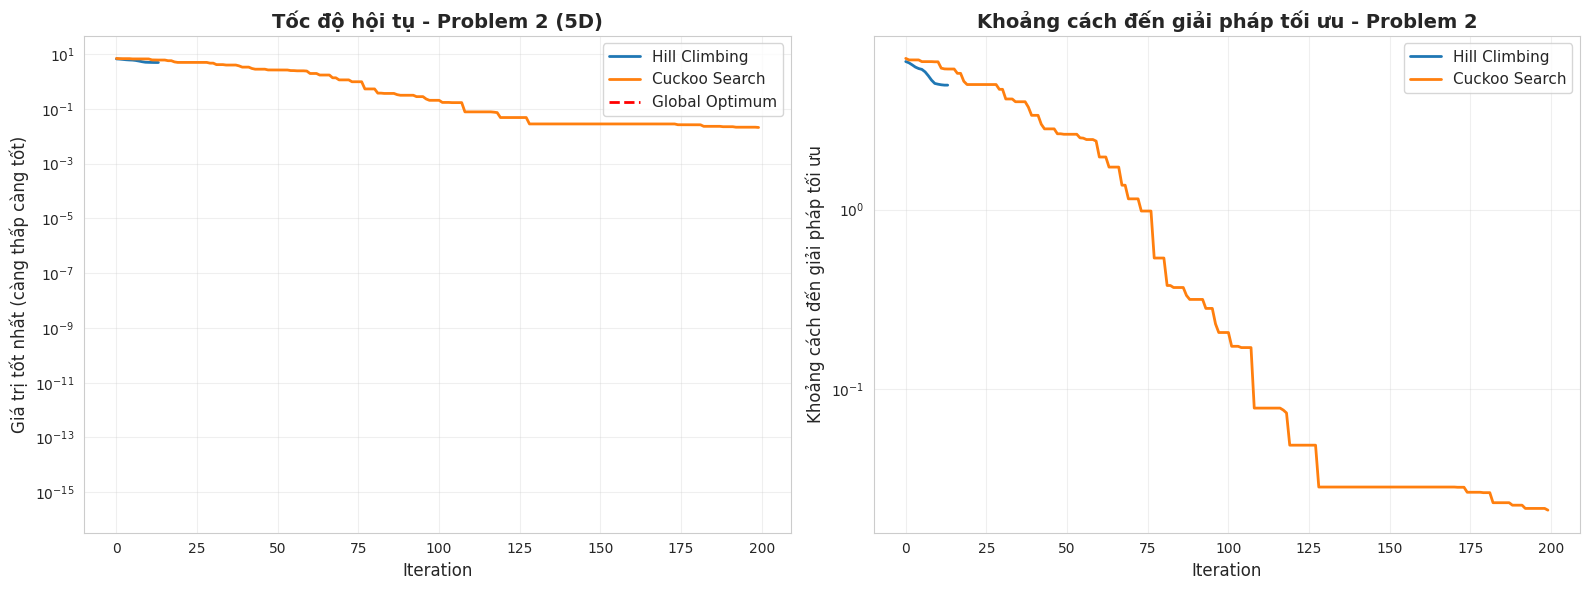

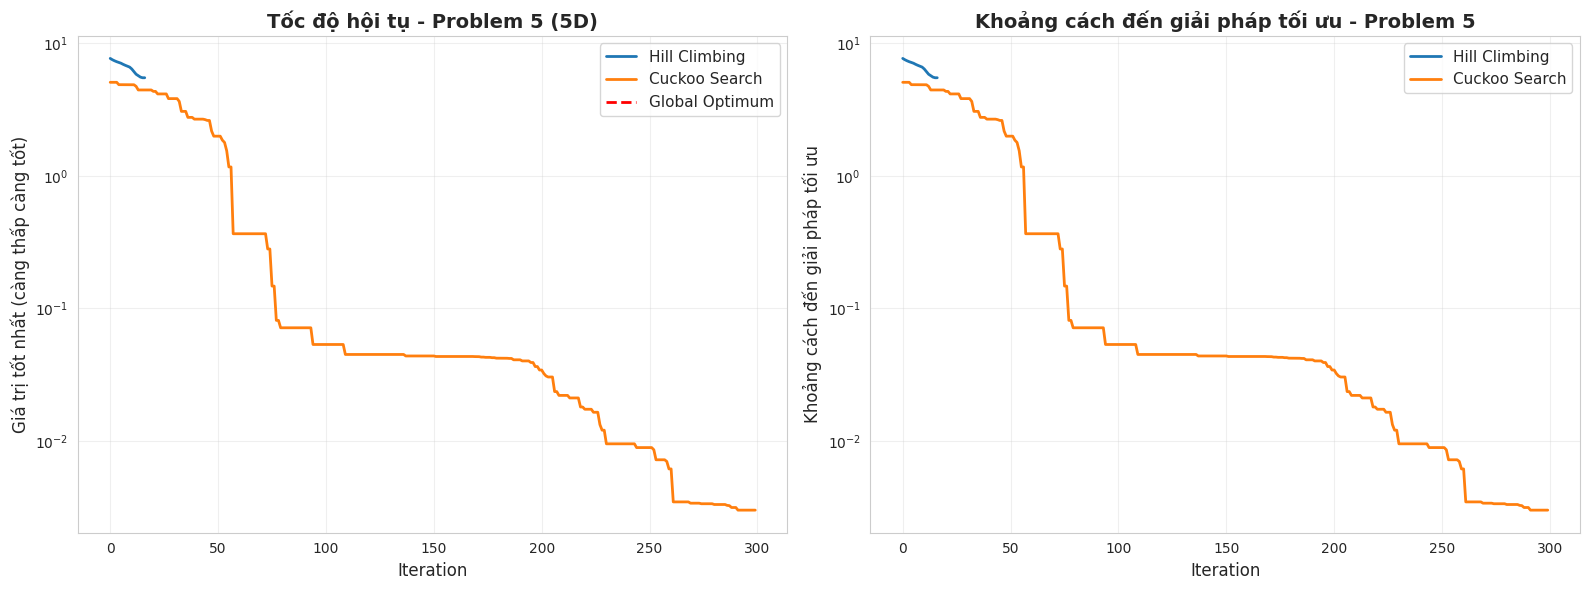

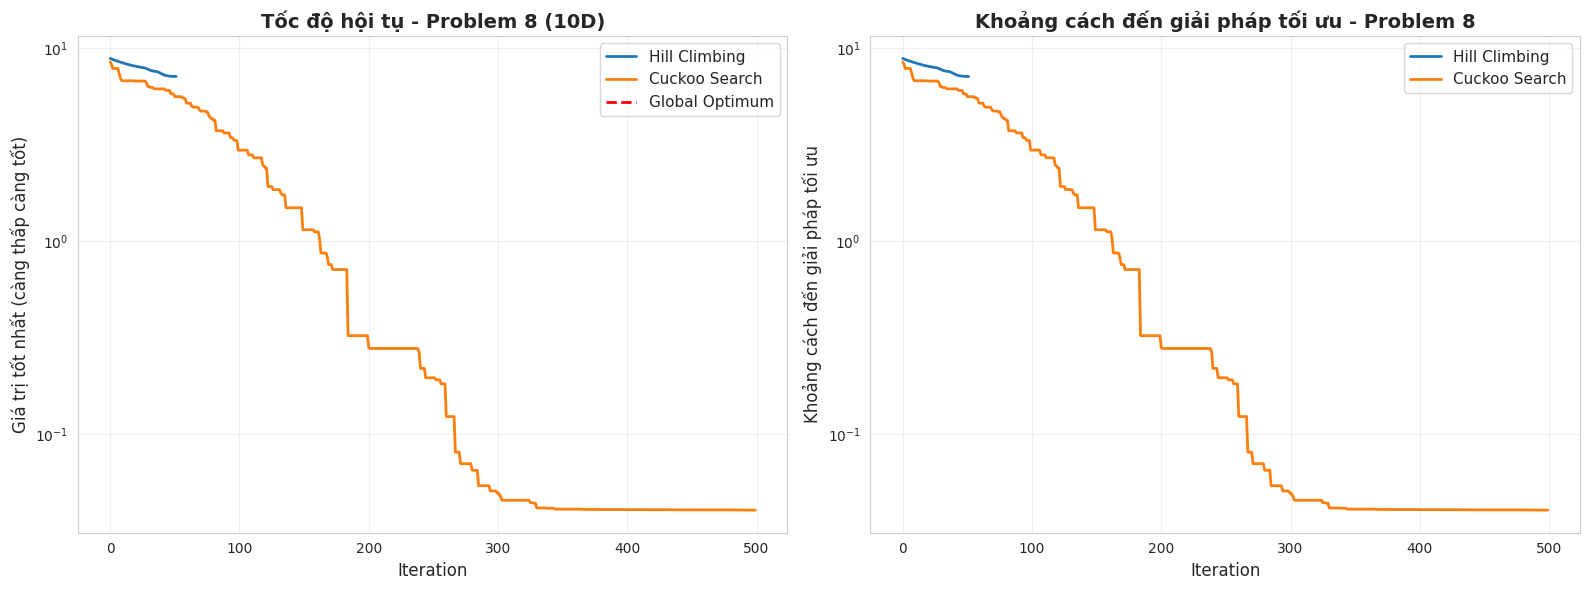

In [13]:
def plot_convergence(results_df, problem_num):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    problem_data = results_df[results_df["Problem"] == problem_num]

    if problem_data.empty:
        print(f"No data for problem {problem_num}")
        return

    ax1 = axes[0]
    for _, row in problem_data.iterrows():
        ax1.plot(row["Convergence History"], label=row["Algorithm"], linewidth=2)

    ax1.axhline(y=0.0, color="red", linestyle="--", label="Global Optimum", linewidth=2)
    ax1.set_xlabel("Iteration", fontsize=12)
    ax1.set_ylabel("Giá trị tốt nhất (càng thấp càng tốt)", fontsize=12)
    ax1.set_title(
        f"Tốc độ hội tụ - Problem {problem_num} ({problem_data.iloc[0]['Dimension']}D)",
        fontsize=14,
        fontweight="bold",
    )
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    ax1.set_yscale("log")

    ax2 = axes[1]
    for _, row in problem_data.iterrows():
        distances = [abs(h) for h in row["Convergence History"]]
        ax2.plot(distances, label=row["Algorithm"], linewidth=2)

    ax2.set_xlabel("Iteration", fontsize=12)
    ax2.set_ylabel("Khoảng cách đến giải pháp tối ưu", fontsize=12)
    ax2.set_title(
        f"Khoảng cách đến giải pháp tối ưu - Problem {problem_num}",
        fontsize=14,
        fontweight="bold",
    )
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)
    ax2.set_yscale("log")

    plt.tight_layout()
    plt.show()


for prob in [2, 5, 8]:
    if prob in all_results["Problem"].values:
        plot_convergence(all_results, prob)

### 5.2 Metric 2: Solution Quality

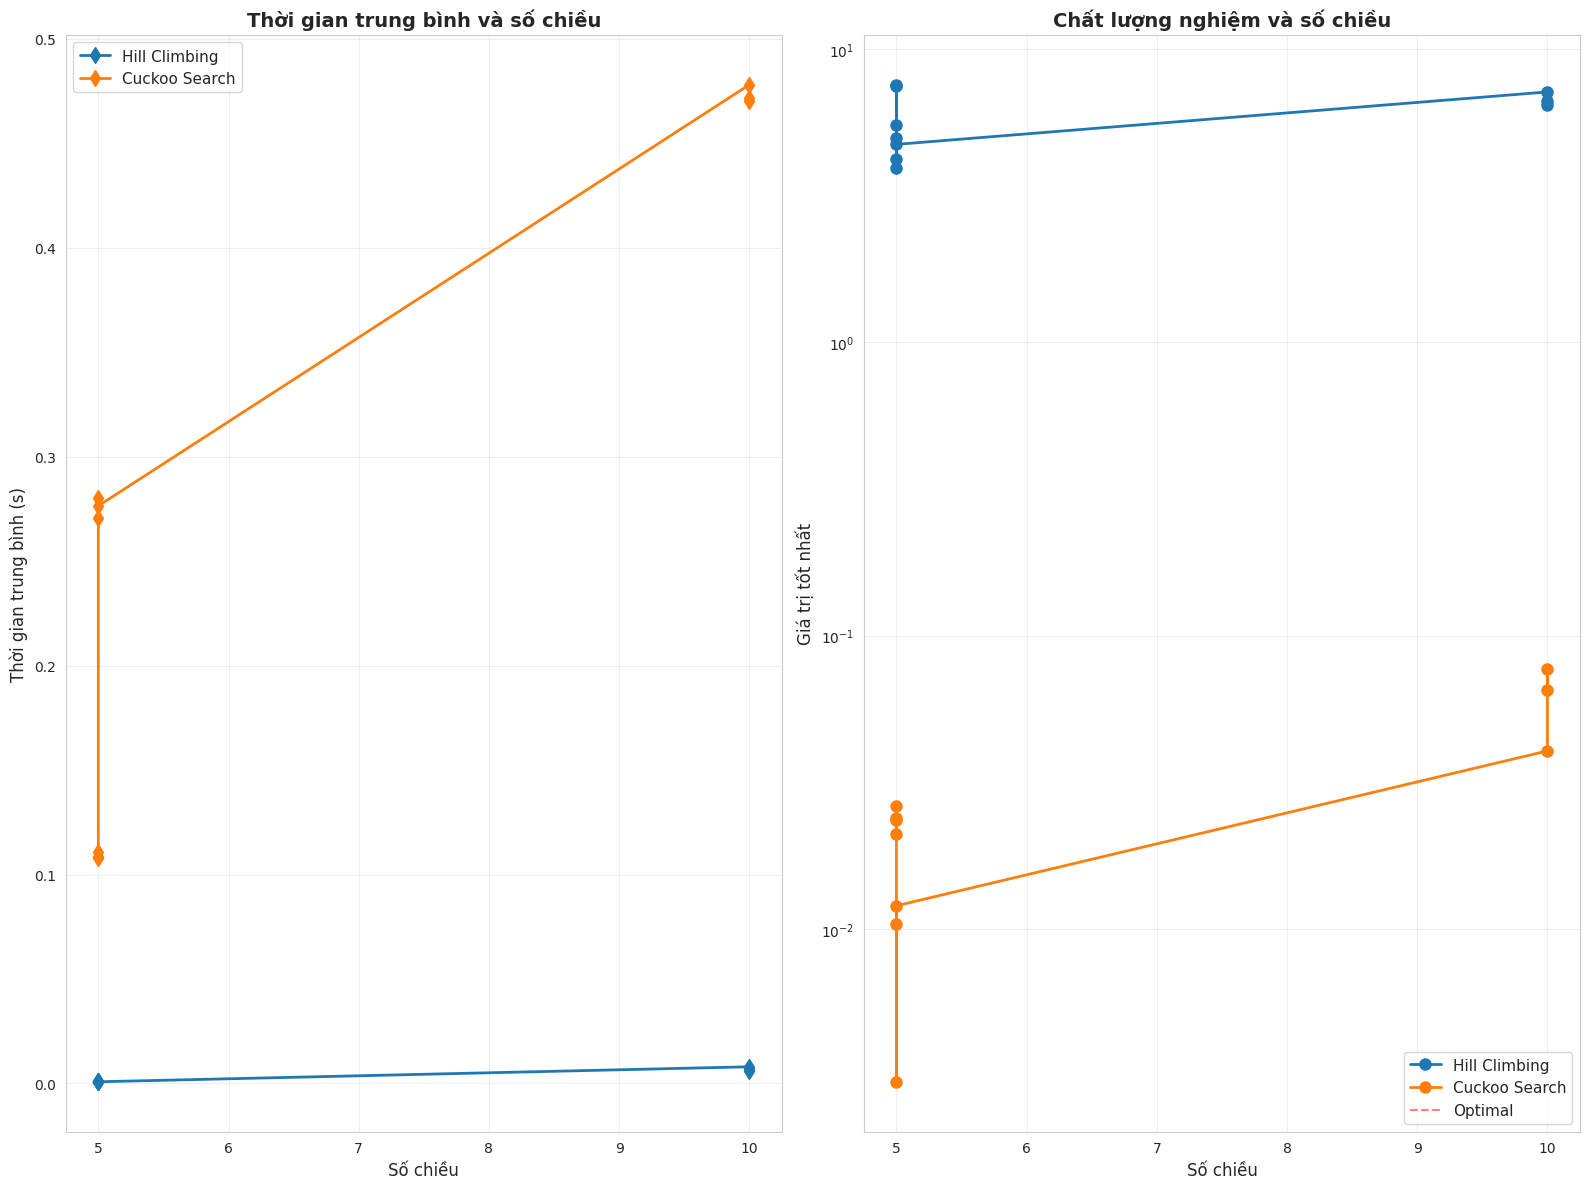

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(16, 12))

# Best Value vs Dimension
ax1 = axes[1]
for algo in all_results["Algorithm"].unique():
    data = all_results[all_results["Algorithm"] == algo].sort_values("Dimension")
    ax1.plot(
        data["Dimension"],
        data["Best Value"],
        marker="o",
        label=algo,
        linewidth=2,
        markersize=8,
    )
ax1.axhline(y=0.0, color="red", linestyle="--", alpha=0.5, label="Optimal")
ax1.set_xlabel("Số chiều", fontsize=12)
ax1.set_ylabel("Giá trị tốt nhất", fontsize=12)
ax1.set_title("Chất lượng nghiệm và số chiều", fontsize=14, fontweight="bold")
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_yscale("log")

# Execution Time
ax3 = axes[0]
for algo in all_results["Algorithm"].unique():
    data = all_results[all_results["Algorithm"] == algo].sort_values("Dimension")
    ax3.plot(
        data["Dimension"],
        data["Mean Time (s)"],
        marker="d",
        label=algo,
        linewidth=2,
        markersize=8,
    )
ax3.set_xlabel("Số chiều", fontsize=12)
ax3.set_ylabel("Thời gian trung bình (s)", fontsize=12)
ax3.set_title("Thời gian trung bình và số chiều", fontsize=14, fontweight="bold")
ax3.legend(fontsize=11)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 5.3 Statistical Summary

In [11]:
summary_stats = (
    all_results.groupby("Algorithm")
    .agg(
        {
            "Best Value": ["mean", "std", "min"],
            "Mean Value": ["mean", "std"],
            "Mean Time (s)": ["mean", "std"],
            "Evaluations": ["mean"],
        }
    )
    .round(6)
)

print("\n" + "=" * 100)
print("COMPREHENSIVE STATISTICAL SUMMARY")
print("=" * 100)
print(summary_stats)

# Rankings
ranking_metrics = (
    all_results.groupby("Algorithm")
    .agg(
        {
            "Best Value": "mean",
            "Mean Time (s)": "mean",
            "Std Value": "mean",
        }
    )
    .reset_index()
)

ranking_metrics["Quality Rank"] = ranking_metrics["Best Value"].rank(ascending=True)
ranking_metrics["Speed Rank"] = ranking_metrics["Mean Time (s)"].rank(ascending=True)
ranking_metrics["Robustness Rank"] = ranking_metrics["Std Value"].rank(ascending=True)
ranking_metrics["Overall Rank"] = (
    ranking_metrics["Quality Rank"]
    + ranking_metrics["Speed Rank"]
    + ranking_metrics["Robustness Rank"]
) / 3

print("\n" + "=" * 100)
print("ALGORITHM RANKINGS")
print("=" * 100)
print(
    ranking_metrics.sort_values("Overall Rank")[
        ["Algorithm", "Quality Rank", "Speed Rank", "Robustness Rank", "Overall Rank"]
    ].to_string(index=False)
)


COMPREHENSIVE STATISTICAL SUMMARY
              Best Value                     Mean Value            \
                    mean       std       min       mean       std   
Algorithm                                                           
Cuckoo Search   0.030272  0.024002  0.003008   0.062932  0.034021   
Hill Climbing   5.857781  1.365769  3.920083   8.556600  0.342529   

              Mean Time (s)           Evaluations  
                       mean       std        mean  
Algorithm                                          
Cuckoo Search       0.26838  0.159179     14400.0  
Hill Climbing       0.00274  0.003015       385.5  

ALGORITHM RANKINGS
    Algorithm  Quality Rank  Speed Rank  Robustness Rank  Overall Rank
Cuckoo Search           1.0         2.0              1.0      1.333333
Hill Climbing           2.0         1.0              2.0      1.666667


### 5.4 Radar Chart

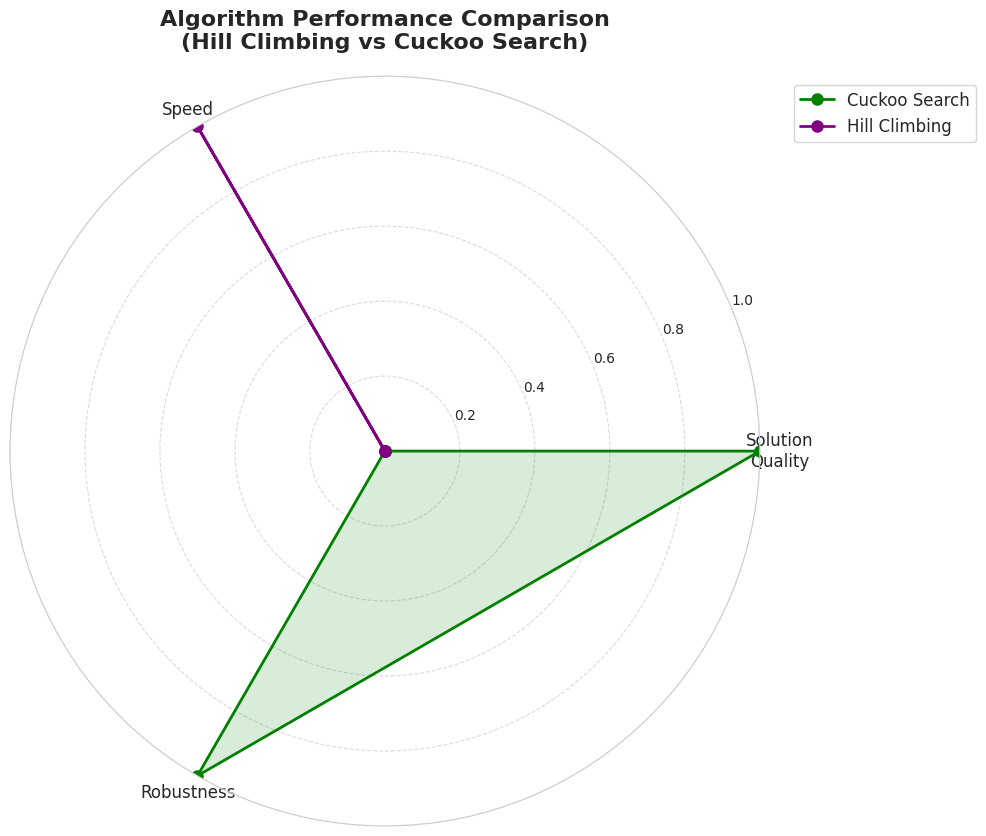

In [12]:
def normalize_metric(values, higher_is_better=True):
    min_val, max_val = values.min(), values.max()
    if max_val == min_val:
        return np.ones_like(values)
    normalized = (values - min_val) / (max_val - min_val)
    return normalized if higher_is_better else 1 - normalized


radar_data = (
    all_results.groupby("Algorithm")
    .agg(
        {
            "Best Value": "mean",
            "Mean Time (s)": "mean",
            "Std Value": "mean",
        }
    )
    .reset_index()
)

radar_data["Quality_norm"] = normalize_metric(radar_data["Best Value"].values, False)
radar_data["Speed_norm"] = normalize_metric(radar_data["Mean Time (s)"].values, False)
radar_data["Robustness_norm"] = normalize_metric(radar_data["Std Value"].values, False)

categories = ["Solution\nQuality", "Speed", "Robustness"]
N = len(categories)
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection="polar"))
colors = ["green", "purple"]

for idx, row in radar_data.iterrows():
    values = [row["Quality_norm"], row["Speed_norm"], row["Robustness_norm"]]
    values += values[:1]
    ax.plot(
        angles,
        values,
        "o-",
        linewidth=2,
        label=row["Algorithm"],
        color=colors[idx],
        markersize=8,
    )
    ax.fill(angles, values, alpha=0.15, color=colors[idx])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, size=12)
ax.set_ylim(0, 1)
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(["0.2", "0.4", "0.6", "0.8", "1.0"], size=10)
ax.grid(True, linestyle="--", alpha=0.7)
ax.set_title(
    "Algorithm Performance Comparison\n(Hill Climbing vs Cuckoo Search)",
    size=16,
    fontweight="bold",
    pad=20,
)
ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.0), fontsize=12)

plt.tight_layout()
plt.show()

## 6. Conclusions

### Kết luận từ việc so sánh trên Ackley Function:

#### 1. **Convergence Speed (Tốc độ hội tụ)**
- **Hill Climbing**: Converge nhanh ban đầu nhưng stuck ở local minima
- **Cuckoo Search**: Converge ổn định nhờ Levy flight, escape local minima tốt

#### 2. **Computational Complexity (Độ phức tạp)**
- **Hill Climbing**: Rất nhanh, O(n) neighbors per iteration
- **Cuckoo Search**: Moderate cost, balance giữa exploration và exploitation

#### 3. **Robustness (Tính bền vững)**
- **Hill Climbing**: High variance, phụ thuộc initial solution
- **Cuckoo Search**: More consistent, population-based approach

#### 4. **Scalability (Khả năng mở rộng)**
- **Hill Climbing**: Struggle với high dimensions
- **Cuckoo Search**: Better scaling với Levy flight mechanism

### Khuyến nghị:
- **Hill Climbing**: Quick local optimization, refinement
- **Cuckoo Search**: Global optimization với nhiều local minima
- **Cuckoo's advantage**: Levy flight giúp explore search space tốt hơn random walk